In [1]:
import evaluate
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset, DatasetDict
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
dataset = pd.read_csv('dataset/summary_dataset.csv')
dataset.head()

,text,desc,class
0,"ФЕДЕРАЛЬНАЯ СЛУЖБА ПО ЭКОЛОГИЧЕСКОМУ, ТЕХНОЛОГ...",Заявление о политике Ростехнадзора в отношении...,application
1,ЦЕНТРАЛЬНЫЙ БАНК РОССИЙСКОЙ ФЕДЕРАЦИИ ЗАЯВЛЕНИ...,Заявление Банка России от 15.01.2021 О приверж...,application
2,ЗАЯВЛЕНИЕ О ВЫПОЛНЕНИИ ВНУТРИГОСУДАРСТВЕННЫХ П...,Заявление о выполнении внутригосударственных п...,application
3,ЗАЯВЛЕНИЕ О ВЫПОЛНЕНИИ ВНУТРИГОСУДАРСТВЕННЫХ П...,Заявление о выполнении внутригосударственных п...,application
4,МИНИСТЕРСТВО ИНОСТРАННЫХ ДЕЛ РОССИЙСКОЙ ФЕДЕРА...,Заявление официального представителя МИД Росси...,application


In [3]:
df_train, df_val = train_test_split(
    dataset, test_size=0.2, random_state=42, stratify=dataset["class"].tolist())

In [4]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

In [5]:
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
})

In [6]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'desc', 'class'],
        num_rows: 154
    })
    validation: Dataset({
        features: ['text', 'desc', 'class'],
        num_rows: 39
    })
})

In [7]:
# Load the tokenizer, model, and data collator
MODEL_NAME = "ai-forever/ruT5-large"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
dataset["desc_len"] = dataset.desc.apply(
    lambda x: len(tokenizer(x)["input_ids"]))
dataset.desc_len.max()

134

<Axes: >

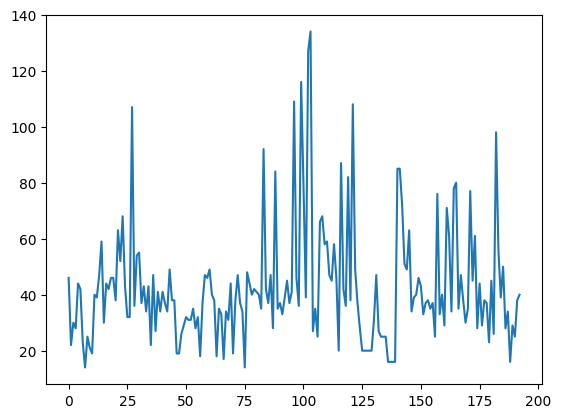

In [9]:
dataset.desc_len.plot()

In [10]:
prefix = "Напиши заголовок для документа: "

# Define the preprocessing function


def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["desc"],
                       max_length=150,
                       truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
tokenized_dataset = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [12]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'desc', 'class', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 154
    })
    validation: Dataset({
        features: ['text', 'desc', 'class', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 39
    })
})

In [13]:
metric = evaluate.load("rouge")

In [14]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                     for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip()))
                      for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels, use_stemmer=True)

    return result

In [15]:
# Global Parameters
L_RATE = 3e-4
BATCH_SIZE = 4
PER_DEVICE_EVAL_BATCH = 8
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 1
NUM_EPOCHS = 5

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="output_ai-forever-ruT5-large",
    evaluation_strategy="epoch",
    learning_rate=L_RATE,
    report_to=None,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=SAVE_TOTAL_LIM,
    num_train_epochs=NUM_EPOCHS,
    predict_with_generate=True,
    push_to_hub=False,
    overwrite_output_dir=True,
    save_strategy="epoch",
    greater_is_better=True,
    load_best_model_at_end=True

)

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [17]:
trainer.train()

  0%|          | 0/195 [00:00<?, ?it/s]

/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 1.2299271821975708, 'eval_rouge1': 0.29948822654163987, 'eval_rouge2': 0.16089764935918782, 'eval_rougeL': 0.28893173355597124, 'eval_rougeLsum': 0.30039013383494984, 'eval_runtime': 3.7621, 'eval_samples_per_second': 10.367, 'eval_steps_per_second': 1.329, 'epoch': 1.0}


/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.7406774759292603, 'eval_rouge1': 0.39123076389092104, 'eval_rouge2': 0.33756769766534, 'eval_rougeL': 0.38886619365304764, 'eval_rougeLsum': 0.391662673015376, 'eval_runtime': 3.844, 'eval_samples_per_second': 10.146, 'eval_steps_per_second': 1.301, 'epoch': 2.0}


/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.664673924446106, 'eval_rouge1': 0.4146453818694622, 'eval_rouge2': 0.3451980000056923, 'eval_rougeL': 0.4004224970386685, 'eval_rougeLsum': 0.41020579234232585, 'eval_runtime': 3.8907, 'eval_samples_per_second': 10.024, 'eval_steps_per_second': 1.285, 'epoch': 3.0}


/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.5705946087837219, 'eval_rouge1': 0.4185619307791254, 'eval_rouge2': 0.3892589959897652, 'eval_rougeL': 0.42305728459574615, 'eval_rougeLsum': 0.4223390402123435, 'eval_runtime': 3.9332, 'eval_samples_per_second': 9.916, 'eval_steps_per_second': 1.271, 'epoch': 4.0}


/home/pc/Desktop/cp_ufo/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.5380449891090393, 'eval_rouge1': 0.42664069213842976, 'eval_rouge2': 0.38574682177921044, 'eval_rougeL': 0.427639190874485, 'eval_rougeLsum': 0.4282831547537431, 'eval_runtime': 4.0288, 'eval_samples_per_second': 9.68, 'eval_steps_per_second': 1.241, 'epoch': 5.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 146.638, 'train_samples_per_second': 5.251, 'train_steps_per_second': 1.33, 'train_loss': 0.8098511524689503, 'epoch': 5.0}


TrainOutput(global_step=195, training_loss=0.8098511524689503, metrics={'train_runtime': 146.638, 'train_samples_per_second': 5.251, 'train_steps_per_second': 1.33, 'train_loss': 0.8098511524689503, 'epoch': 5.0})

In [23]:
sample = dataset_dict["validation"][9]
inputs = prefix + sample["text"]

inputs = tokenizer(inputs, return_tensors="pt")
inputs = inputs.to("cuda")
outputs = model.generate(**inputs, max_new_tokens=150,
                         repetition_penalty=4.0, num_beams=3, do_sample=True)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(sample["desc"])
print(answer)

Договор между СССР и Тунисской Республикой о правовой помощи по гражданским и уголовным делам (подписан в г. Москве 26.06.1984)
Договор между СССР и Тунисской Республикой о правовой помощи и правовых отношениях по уголовным делам (Подписан в г. Москве 26.06.1984)


In [24]:
model.save_pretrained("output" + MODEL_NAME.replace("/", "-"))
tokenizer.save_pretrained("output" + MODEL_NAME.replace("/", "-"))

('outputai-forever-ruT5-large/tokenizer_config.json',
 'outputai-forever-ruT5-large/special_tokens_map.json',
 'outputai-forever-ruT5-large/spiece.model',
 'outputai-forever-ruT5-large/added_tokens.json')

In [2]:
import pandas as pd
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration

df = pd.read_csv("dataset/summary_dataset.csv")

MODEL_NAME = "outputai-forever-ruT5-large"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
sample = df.iloc[2]
prefix = "Напиши заголовок для документа: "
inputs = prefix + sample["text"]

inputs = tokenizer(inputs, return_tensors="pt",
                   max_length=512, truncation=True)
outputs = model.generate(**inputs, max_new_tokens=150, repetition_penalty=4.0)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(sample["desc"])
print(answer)

Заявление о выполнении внутригосударственных процедур, необходимых для вступления в силу Договора о Таможенном кодексе Евразийского экономического союза от 11 апреля 2017 года
Договор о внутригосударственном кодексе Евразийского экономического союза от 11 АПРЕЛЯ 2017 г. N 318 О внесении изменений во внутренний порядок введения товаров и услуг, необходимых для вступления их на территорию евразийского союзного договора (Подписанавтрасийском таможном комитетм Таможенного кодекса)
